# Phân Tích Benchmark: Thuật Toán Giải Hashiwokakero

## Cấu Trúc Phân Tích

### **Phần 1: So Sánh Các Phiên Bản A***
- So sánh A* trên CNF: Basic, Weighted, MOMs, JW
- So sánh A* trên Grid: AStarSolver (edge-based)
- Đánh giá heuristic và hiệu suất

### **Phần 2: So Sánh Tổng Quan Các Thuật Toán**
- PySATSolver (SAT-based)
- A* variants (Heuristic search)
- Backtracking (Traditional search)
- BruteForce (Exhaustive search)
- Đánh giá tổng thể và xếp hạng

---
## Setup & Data Loading

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Styling
sns.set_theme(style="white", palette="tab10")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 10

# Color palette
colors = {
    'PySATSolver': '#2ecc71',
    'AStar_Basic': '#3498db',
    'AStar_Weighted': '#9b59b6',
    'AStar_MOMs': '#f14c92',
    'AStarSolver': "#d20c0c",
    'BacktrackingSolver': '#e67e22',
    'BruteForceSolver': "#F6FA23"
}

print("✓ Libraries loaded")

✓ Libraries loaded


In [85]:
# Load and merge all benchmark data
print("Loading benchmark data from multiple files...")

# Load all benchmark files
df1 = pd.read_csv("data/outputs/benchmark_report_1.0.csv")  # Traditional: PySAT, AStarSolver, Backtracking, BruteForce
df2 = pd.read_csv("data/outputs/benchmark_report_1.1.csv")  # A* Variants: MOMs
df3 = pd.read_csv("data/outputs/benchmark_report_1.2.csv")  # A* Variants: Basic, Weighted

# Merge datasets (giữ PySATSolver từ file 1.0)
df_combined = pd.concat([df1, df2, df3], ignore_index=True)

# Remove duplicate PySATSolver entries (keep from file 1.0)
df = df_combined.drop_duplicates(subset=['Input', 'Solver'], keep='first')

# Clean data
df["Time (s)"] = pd.to_numeric(df["Time (s)"], errors="coerce")
df["Memory (MB)"] = pd.to_numeric(df["Memory (MB)"], errors="coerce")
df["Correct"] = df["Correct"].astype(bool)
df["Timeout"] = df["Status"] == "TIMEOUT"

# Filter successful runs (no timeout)
df_success = df[~df["Timeout"]].copy()

# Categorize solvers
all_solvers = sorted(df['Solver'].unique().tolist())
astar_variants = sorted([s for s in all_solvers if 'AStar_' in s])  # AStar_Basic, AStar_Weighted, AStar_MOMs, AStar_JW
traditional_solvers = ['BacktrackingSolver', 'BruteForceSolver']
sat_solver = ['PySATSolver']

print(f"✓ Loaded {len(df)} records (merged from 3 files)")
print(f"✓ {df['Input'].nunique()} test inputs")
print(f"✓ {len(all_solvers)} solvers")
print(f"Danh sách Solvers:")
print(f"  - SAT Solver: {sat_solver}")
print(f"  - A* Variants (CNF): {astar_variants}")
print(f"  - Traditional: {[s for s in traditional_solvers if s in all_solvers]}")
if 'AStarSolver' in all_solvers:
    print(f"  - A* Standard (Edge-based): ['AStarSolver']")


Loading benchmark data from multiple files...
✓ Loaded 77 records (merged from 3 files)
✓ 11 test inputs
✓ 7 solvers
Danh sách Solvers:
  - SAT Solver: ['PySATSolver']
  - A* Variants (CNF): ['AStar_Basic', 'AStar_MOMs', 'AStar_Weighted']
  - Traditional: ['BacktrackingSolver', 'BruteForceSolver']
  - A* Standard (Edge-based): ['AStarSolver']


C:\Users\GIGA\AppData\Local\Temp\ipykernel_22172\3626004816.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Time (s)"] = pd.to_numeric(df["Time (s)"], errors="coerce")
C:\Users\GIGA\AppData\Local\Temp\ipykernel_22172\3626004816.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Memory (MB)"] = pd.to_numeric(df["Memory (MB)"], errors="coerce")
C:\Users\GIGA\AppData\Local\Temp\ipykernel_22172\3626004816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

---

# PHẦN 1: SO SÁNH CÁC PHIÊN BẢN A*

## 1.1. A* Variants trên CNF (Clause-based)
- **AStar_Basic**: Heuristic đơn giản (đếm số cầu còn thiếu)
- **AStar_Weighted**: Heuristic có trọng số (ưu tiên degree constraints)
- **AStar_MOMs**: Dynamic variable ordering (MOMs heuristic)


In [86]:
# Phân loại solvers
astar_cnf = sorted([s for s in all_solvers if 'AStar_' in s])  # CNF-based A*
astar_grid = ['AStarSolver'] if 'AStarSolver' in all_solvers else []  # Grid-based A*

print("="*80)
print("PHẦN 1: SO SÁNH CÁC PHIÊN BẢN A*")
print("="*80)
print(f"\n🔹 A* trên CNF: {astar_cnf}")
print(f"🔹 A* trên Grid: {astar_grid}")
print("\n" + "="*80)

PHẦN 1: SO SÁNH CÁC PHIÊN BẢN A*

🔹 A* trên CNF: ['AStar_Basic', 'AStar_MOMs', 'AStar_Weighted']
🔹 A* trên Grid: ['AStarSolver']



In [87]:
# Thống kê A* CNF variants
if len(astar_cnf) > 0:
    astar_cnf_stats = pd.DataFrame()
    
    for solver in astar_cnf:
        s_data = df[df['Solver'] == solver]
        s_success = s_data[~s_data['Timeout']]
        
        astar_cnf_stats.loc[solver, 'Success'] = int(s_data['Correct'].sum())
        astar_cnf_stats.loc[solver, 'Rate_%'] = round(s_data['Correct'].mean() * 100, 1)
        astar_cnf_stats.loc[solver, 'Timeout'] = int(s_data['Timeout'].sum())
        
        if len(s_success) > 0:
            astar_cnf_stats.loc[solver, 'Avg_Time_s'] = round(s_success['Time (s)'].mean(), 4)
            astar_cnf_stats.loc[solver, 'Avg_Mem_MB'] = round(s_success['Memory (MB)'].mean(), 2)
    
    print("\n📊 A* CNF Variants Statistics:")
    print(astar_cnf_stats.sort_values('Rate_%', ascending=False))

# Thống kê A* Grid
if len(astar_grid) > 0:
    astar_grid_stats = pd.DataFrame()
    
    for solver in astar_grid:
        s_data = df[df['Solver'] == solver]
        s_success = s_data[~s_data['Timeout']]
        
        astar_grid_stats.loc[solver, 'Success'] = int(s_data['Correct'].sum())
        astar_grid_stats.loc[solver, 'Rate_%'] = round(s_data['Correct'].mean() * 100, 1)
        astar_grid_stats.loc[solver, 'Timeout'] = int(s_data['Timeout'].sum())
        
        if len(s_success) > 0:
            astar_grid_stats.loc[solver, 'Avg_Time_s'] = round(s_success['Time (s)'].mean(), 4)
            astar_grid_stats.loc[solver, 'Avg_Mem_MB'] = round(s_success['Memory (MB)'].mean(), 2)
    
    print("\n📊 A* Grid-based Statistics:")
    print(astar_grid_stats)


📊 A* CNF Variants Statistics:
                Success  Rate_%  Timeout  Avg_Time_s  Avg_Mem_MB
AStar_Basic         1.0     9.1     10.0     13.6836        0.11
AStar_MOMs          1.0     9.1     10.0      3.0016        0.25
AStar_Weighted      1.0     9.1     10.0     18.1079        0.11

📊 A* Grid-based Statistics:
             Success  Rate_%  Timeout  Avg_Time_s  Avg_Mem_MB
AStarSolver      4.0    36.4      5.0      3.9473       16.58


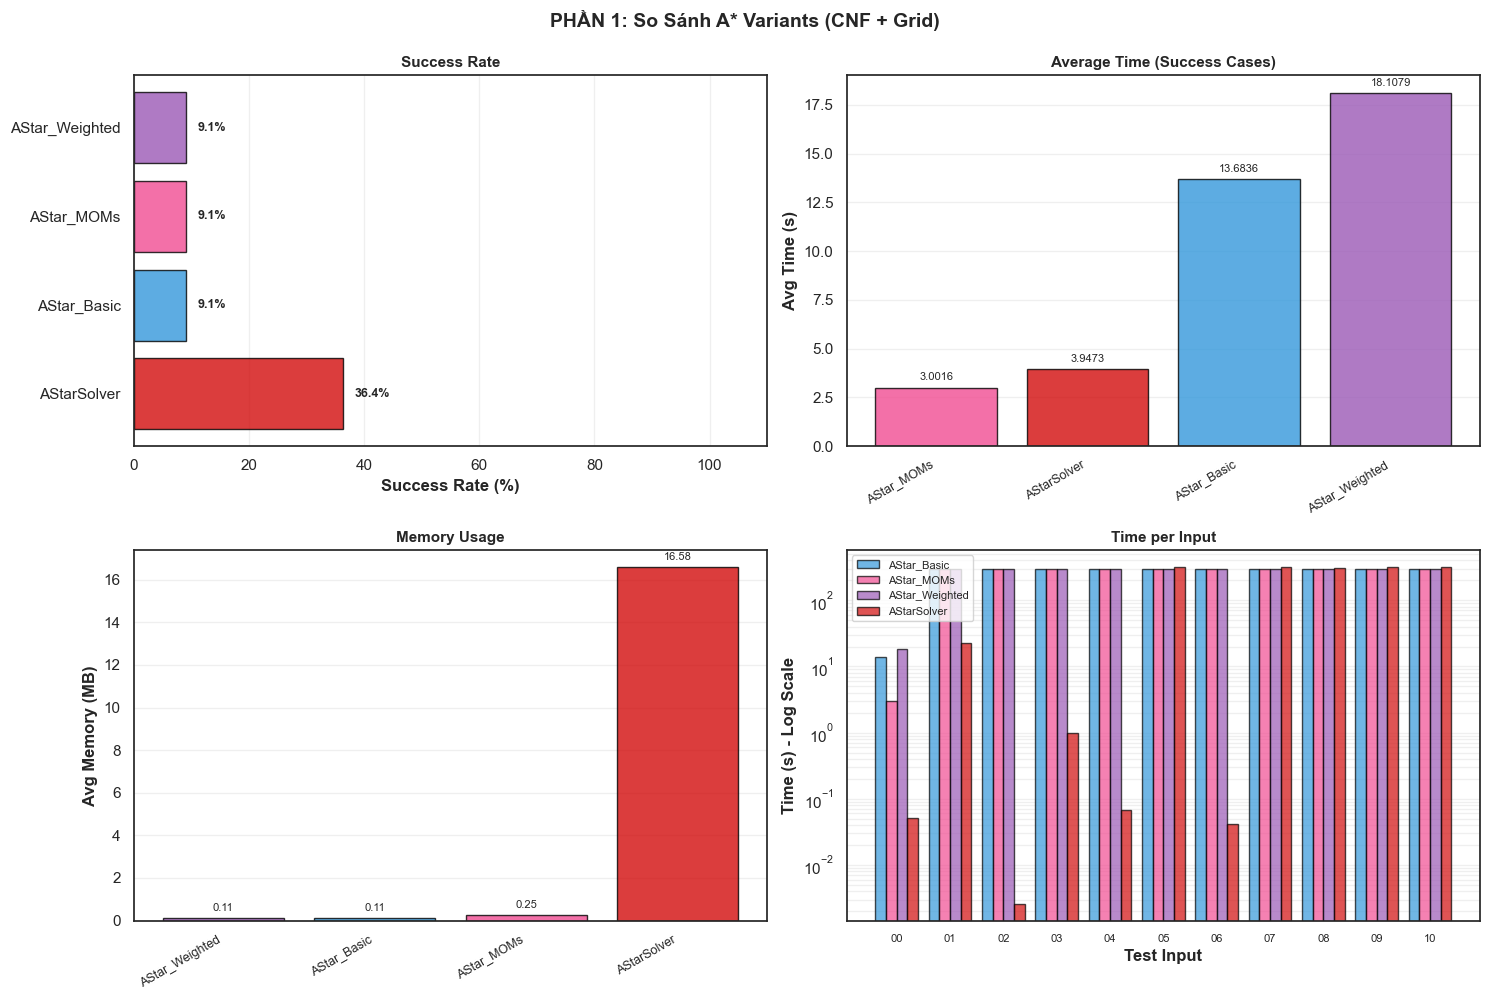

In [97]:
# Biểu đồ so sánh A* CNF variants
all_astar = astar_cnf + astar_grid
astar_data = df[df['Solver'].isin(all_astar)].copy()
astar_success = astar_data[~astar_data['Timeout']].copy()

if len(all_astar) > 0 and len(astar_success) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Success Rate
    ax1 = axes[0, 0]
    success_rates = []
    for s in all_astar:
        s_data = astar_data[astar_data['Solver'] == s]
        success_rates.append((s, s_data['Correct'].mean() * 100))
    success_rates.sort(key=lambda x: x[1], reverse=True)
    
    bars1 = ax1.barh([x[0] for x in success_rates], [x[1] for x in success_rates],
                     color=[colors.get(s, '#95a5a6') for s, _ in success_rates],
                     alpha=0.8, edgecolor='black')
    ax1.set_xlabel('Success Rate (%)', fontweight='bold')
    ax1.set_title('Success Rate', fontweight='bold', fontsize=11)
    ax1.set_xlim(0, 110)
    for i, (s, v) in enumerate(success_rates):
        ax1.text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold', fontsize=9)
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Average Time
    ax2 = axes[0, 1]
    time_data = astar_success.groupby('Solver')['Time (s)'].mean().sort_values()
    bars2 = ax2.bar(range(len(time_data)), time_data.values,
                    color=[colors.get(s, '#95a5a6') for s in time_data.index],
                    alpha=0.8, edgecolor='black')
    ax2.set_xticks(range(len(time_data)))
    ax2.set_xticklabels(time_data.index, rotation=30, ha='right', fontsize=9)
    ax2.set_ylabel('Avg Time (s)', fontweight='bold')
    ax2.set_title('Average Time (Success Cases)', fontweight='bold', fontsize=11)
    for i, v in enumerate(time_data.values):
        ax2.text(i, v + max(time_data)*0.02, f'{v:.4f}', ha='center', fontsize=8)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Memory Usage
    ax3 = axes[1, 0]
    mem_data = astar_success.groupby('Solver')['Memory (MB)'].mean().sort_values()
    bars3 = ax3.bar(range(len(mem_data)), mem_data.values,
                    color=[colors.get(s, '#95a5a6') for s in mem_data.index],
                    alpha=0.8, edgecolor='black')
    ax3.set_xticks(range(len(mem_data)))
    ax3.set_xticklabels(mem_data.index, rotation=30, ha='right', fontsize=9)
    ax3.set_ylabel('Avg Memory (MB)', fontweight='bold')
    ax3.set_title('Memory Usage', fontweight='bold', fontsize=11)
    for i, v in enumerate(mem_data.values):
        ax3.text(i, v + max(mem_data)*0.02, f'{v:.2f}', ha='center', fontsize=8)
    ax3.grid(axis='y', alpha=0.3)
    
    # 5. Time by Input (detailed comparison)
    ax5 = axes[1, 1]
    inputs = sorted(astar_data['Input'].unique())
    x = np.arange(len(inputs))
    width = 0.8 / len(all_astar)
    
    for i, solver in enumerate(all_astar):
        times = []
        for inp in inputs:
            val = astar_data[(astar_data['Input']==inp) & (astar_data['Solver']==solver)]['Time (s)'].values
            times.append(val[0] if len(val) > 0 else 300)
        offset = (i - len(all_astar)/2 + 0.5) * width
        ax5.bar(x + offset, times, width, label=solver,
                color=colors.get(solver, '#95a5a6'), alpha=0.7, edgecolor='black')
    
    ax5.set_xlabel('Test Input', fontweight='bold')
    ax5.set_ylabel('Time (s) - Log Scale', fontweight='bold')
    ax5.set_title('Time per Input', fontweight='bold', fontsize=11)
    ax5.set_xticks(x)
    ax5.set_xticklabels([inp.replace('input-', '').replace('.txt', '') for inp in inputs], 
                         rotation=0, fontsize=8)
    ax5.legend(loc='upper left', fontsize=8)
    ax5.set_yscale('log')
    ax5.grid(axis='y', alpha=0.3, which='both')
    

    for i, (s, v) in enumerate(sorted_ranking):
        ax6.text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=9)
    ax6.grid(axis='x', alpha=0.3)
    
    plt.suptitle('PHẦN 1: So Sánh A* Variants (CNF + Grid)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

---
---

# PHẦN 2: SO SÁNH TỔNG QUAN CÁC THUẬT TOÁN

## 2.1. Tất Cả Solvers

Bao gồm:
- **PySATSolver**: SAT-based solver
- **A* Variants**: Heuristic search (CNF + Grid)
- **BacktrackingSolver**: Traditional search with pruning
- **BruteForceSolver**: Exhaustive search

In [89]:
# Overall statistics
print("="*80)
print("PHẦN 2: SO SÁNH TỔNG QUAN TẤT CẢ THUẬT TOÁN")
print("="*80)

overall_stats = pd.DataFrame()
for solver in all_solvers:
    s_data = df[df['Solver'] == solver]
    s_success = s_data[~s_data['Timeout']]
    
    overall_stats.loc[solver, 'Total'] = len(s_data)
    overall_stats.loc[solver, 'Success'] = int(s_data['Correct'].sum())
    overall_stats.loc[solver, 'Rate_%'] = round(s_data['Correct'].mean() * 100, 1)
    overall_stats.loc[solver, 'Timeout'] = int(s_data['Timeout'].sum())
    
    if len(s_success) > 0:
        overall_stats.loc[solver, 'Avg_Time_s'] = round(s_success['Time (s)'].mean(), 4)
        overall_stats.loc[solver, 'Avg_Mem_MB'] = round(s_success['Memory (MB)'].mean(), 2)

overall_stats = overall_stats.sort_values(['Rate_%', 'Avg_Time_s'], ascending=[False, True])
print("\n📊 Overall Statistics:")
print(overall_stats)
print("\n" + "="*80)

PHẦN 2: SO SÁNH TỔNG QUAN TẤT CẢ THUẬT TOÁN

📊 Overall Statistics:
                    Total  Success  Rate_%  Timeout  Avg_Time_s  Avg_Mem_MB
PySATSolver          11.0     11.0   100.0      0.0      0.0774        0.33
AStarSolver          11.0      4.0    36.4      5.0      3.9473       16.58
BacktrackingSolver   11.0      4.0    36.4      7.0      9.5916        0.01
AStar_MOMs           11.0      1.0     9.1     10.0      3.0016        0.25
BruteForceSolver     11.0      1.0     9.1     10.0      7.2939        0.01
AStar_Basic          11.0      1.0     9.1     10.0     13.6836        0.11
AStar_Weighted       11.0      1.0     9.1     10.0     18.1079        0.11



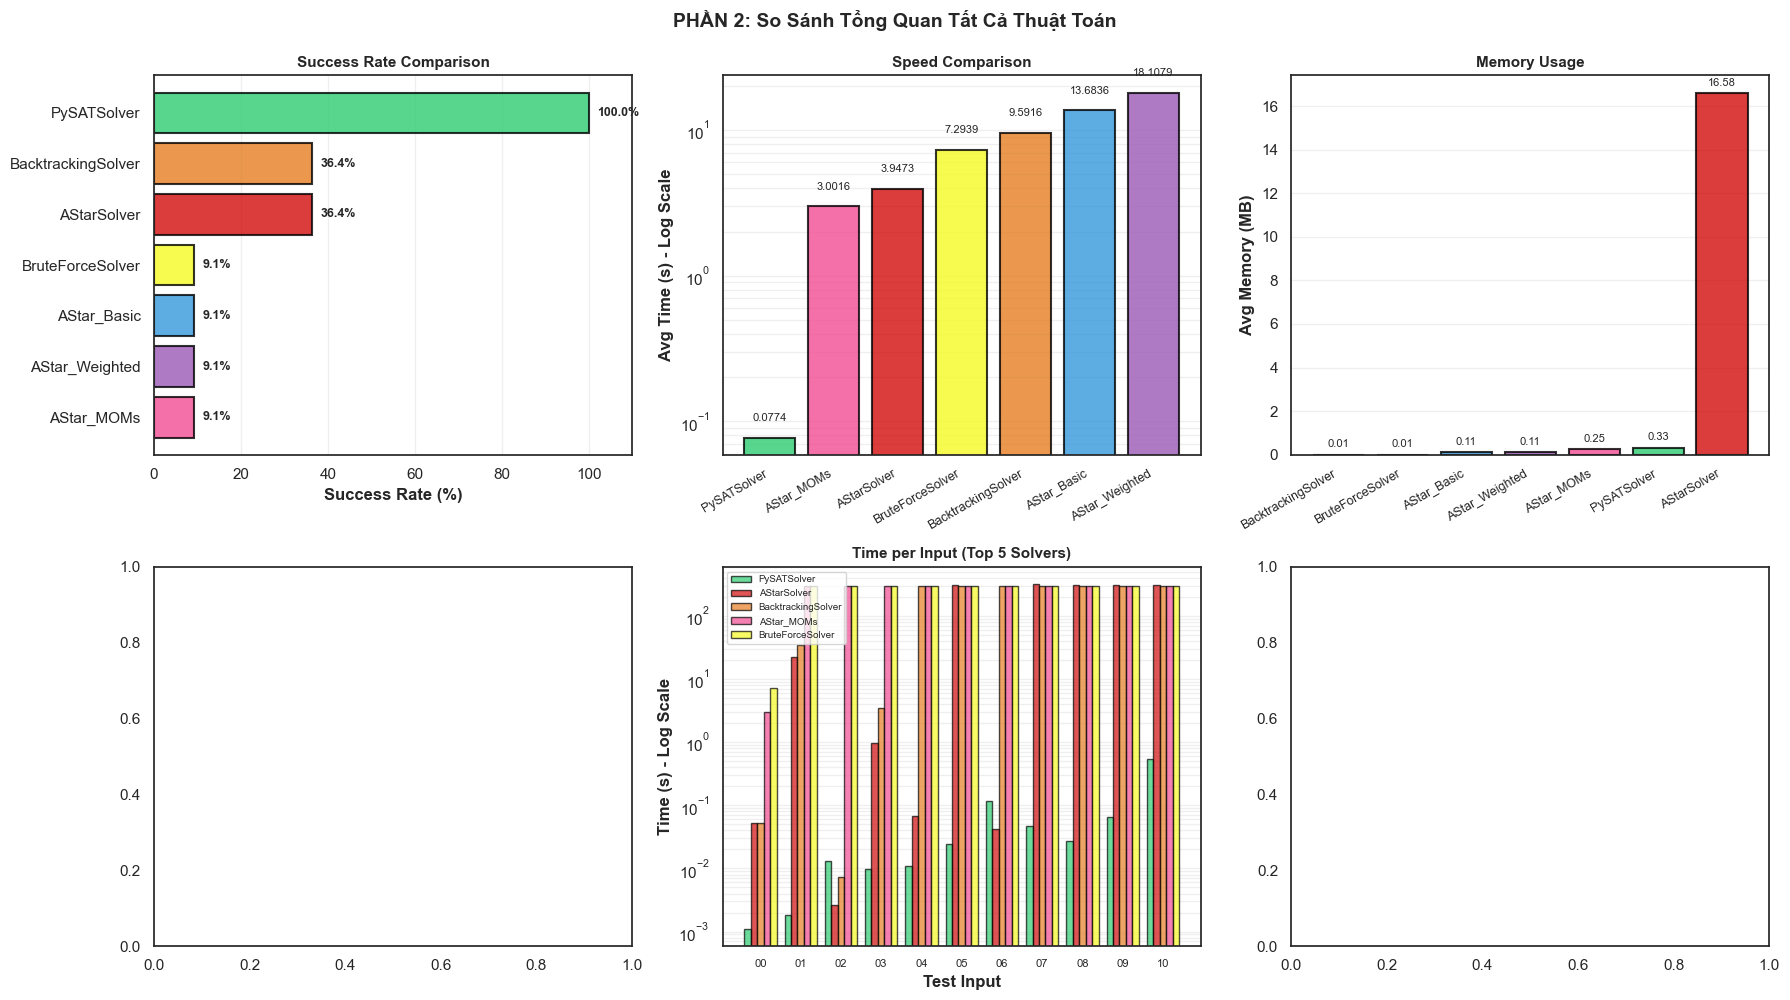

In [ ]:
# Comprehensive comparison charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Success Rate
ax1 = axes[0, 0]
success_data = overall_stats.sort_values('Rate_%', ascending=True)
bars1 = ax1.barh(success_data.index, success_data['Rate_%'],
                 color=[colors.get(s, '#95a5a6') for s in success_data.index],
                 alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Success Rate (%)', fontweight='bold')
ax1.set_title('Success Rate Comparison', fontweight='bold', fontsize=11)
ax1.set_xlim(0, 110)
for i, v in enumerate(success_data['Rate_%']):
    ax1.text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold', fontsize=9)
ax1.grid(axis='x', alpha=0.3)

# 2. Average Time (log scale)
ax2 = axes[0, 1]
time_data = overall_stats.dropna(subset=['Avg_Time_s']).sort_values('Avg_Time_s')
bars2 = ax2.bar(range(len(time_data)), time_data['Avg_Time_s'],
                color=[colors.get(s, '#95a5a6') for s in time_data.index],
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(time_data)))
ax2.set_xticklabels(time_data.index, rotation=30, ha='right', fontsize=9)
ax2.set_ylabel('Avg Time (s) - Log Scale', fontweight='bold')
ax2.set_title('Speed Comparison', fontweight='bold', fontsize=11)
ax2.set_yscale('log')
for i, v in enumerate(time_data['Avg_Time_s']):
    ax2.text(i, v * 1.3, f'{v:.4f}', ha='center', fontsize=8)
ax2.grid(axis='y', alpha=0.3, which='both')

# 3. Memory Usage
ax3 = axes[0, 2]
mem_data = overall_stats.dropna(subset=['Avg_Mem_MB']).sort_values('Avg_Mem_MB')
bars3 = ax3.bar(range(len(mem_data)), mem_data['Avg_Mem_MB'],
                color=[colors.get(s, '#95a5a6') for s in mem_data.index],
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(len(mem_data)))
ax3.set_xticklabels(mem_data.index, rotation=30, ha='right', fontsize=9)
ax3.set_ylabel('Avg Memory (MB)', fontweight='bold')
ax3.set_title('Memory Usage', fontweight='bold', fontsize=11)
for i, v in enumerate(mem_data['Avg_Mem_MB']):
    ax3.text(i, v + max(mem_data['Avg_Mem_MB'])*0.02, f'{v:.2f}', ha='center', fontsize=8)
ax3.grid(axis='y', alpha=0.3)

# 5. Time per Input (detailed)
ax5 = axes[1, 1]
inputs = sorted(df['Input'].unique())
x = np.arange(len(inputs))

# Select top 5 solvers for readability
top_5 = overall_stats.head(5).index.tolist()
width = 0.8 / len(top_5)

for i, solver in enumerate(top_5):
    times = []
    for inp in inputs:
        val = df[(df['Input']==inp) & (df['Solver']==solver)]['Time (s)'].values
        times.append(val[0] if len(val) > 0 else 300)
    offset = (i - len(top_5)/2 + 0.5) * width
    ax5.bar(x + offset, times, width, label=solver,
            color=colors.get(solver, '#95a5a6'), alpha=0.7, edgecolor='black')

ax5.set_xlabel('Test Input', fontweight='bold')
ax5.set_ylabel('Time (s) - Log Scale', fontweight='bold')
ax5.set_title('Time per Input (Top 5 Solvers)', fontweight='bold', fontsize=11)
ax5.set_xticks(x)
ax5.set_xticklabels([inp.replace('input-', '').replace('.txt', '') for inp in inputs], 
                     rotation=0, fontsize=8)
ax5.legend(loc='upper left', fontsize=7)
ax5.set_yscale('log')
ax5.grid(axis='y', alpha=0.3, which='both')


plt.suptitle('PHẦN 2: So Sánh Tổng Quan Tất Cả Thuật Toán', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()